
# Chi lo ha detto: script che riconosce chi ha scritto un tweet usando NLP e la Classificazione

## Obiettivi
---

Date due persone e un tweet cercheremo di stabilire chi dei due è più probabile lo abbia detto. Per far questo dovremo:
- Fornire un metodo che crei una lista di Tweet usando le API di Twitter
- Preprocessare i nostri dati usando NLP
- Fornire un classificatore
- Classificare nuovi tweet in base ai dati già conosciuti

## Contenuto di questo file
---

Mostreremo un primo esempio usando una lista di tweet di Trump e Hillary Clinton così da spiegare cosa fa il codice e come si comporta la classificazione basata su regressione logistica.

Successivamente mostreremo come funziona il nostro script in caso abbiamo più di 2 etichette (aggiungeremo i tweet di Barack Obama).

Faremo anche delle comparazioni tra regressione logistica, KNN e Naive Bayes Multinomiale sia con 2 che con 3 etichette.

Infine, verrà fornito il codice completo del software con caratteristiche aggiuntive (come per esempio indicare utenti diversi da Trump e Hillary Clinton o scegliere un particolare classificatore).

## Promemoria
---

**CI SONO DEI LIMITI IMPOSTI SULLA QUANTITÀ DI INTERAZIONI/OPERAZIONI CHE SI POSSONO FARE NELL'ARCO DI 15 MINUTI SU TWITTER USANDO LE API.**

Il regolamento ufficiale è raggiungibile "[cliccando qui](https://dev.twitter.com/rest/public/rate-limiting)". 

Difficilmente usando questo software si supereranno questi limiti (molti dei quali legati ad aspetti dell’esperienza consumer su Twitter che non vengono affrontati nemmeno, come lo scrivere un Tweet e pubblicarlo), ma è importante essere consapevoli che un uso improprio o smoderato delle API di Twitter potrebbe comportare una limitazione (se non un blocco) sull’uso delle API stesse.

Di seguito inizializziamo le API di Twitter (usando i dati forniti da https://developer.twitter.com/) così da poter cominciare. 

In [6]:
import numpy as np
import twitter, datetime, pandas as pd, numpy as np
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 10)
pd.set_option('min_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 4)
pd.set_option('expand_frame_repr', False)

ck = input("consumer_key: ")
cs = input("consumer_secret: ")
atk = input("access_token_key: ")
ats = input("access_token_secret: ")

ck = 'Tck3q8BKObFM3IspZC4ciF1l9'
cs = 'iMcU8xUMsvAssYBL4wiOOi0kanqZzm7Kl41OGkBNeb86kMIxc0'
atk = '717687265812721667-CZYSrbXWVZW9WheglHCxBhNlRcgCrZL'
ats = '4jC3wHCXqaac9QylANvif60YGeXw4VR8LpJW9iAtA2KvL'

twitter_keys = {
    'consumer_key':        ck,
    'consumer_secret':     cs,
    'access_token_key':    atk,
    'access_token_secret': ats
}

api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret'],
    tweet_mode = 'extended'
)

consumer_key: 
consumer_secret: 
access_token_key: 
access_token_secret: 


**Prima di cominciare**

Utilizzeremo questa classe che non fa altro che inizializzare un oggetto che minera per noi un certo numero di tweet di un utente (che gli indichiamo noi). Questa classe non fa altro che incapsulare la logica di creazione delle liste di tweet che formeranno il nostro dataset.

In [7]:
#TweetMiner di Mike Roman

def checkLenTweet(raw_data):
    data = txt.replace_urls(raw_data,"")
    data = txt.replace_emails(data,"")
    data = txt.replace_emojis(data,"")
    data = txt.replace_user_handles(data,"")
    data = txt.replace_phone_numbers(data,"")
    data = txt.replace_numbers(data,"")
    data = txt.replace_currency_symbols(data,"")
    data = txt.replace_hashtags(data,"")
    if len(data) < 28: #Lunghezza media di un tweet
        return False
    else:
        return True

class TweetMiner(object):

    
    def __init__(self, api, result_limit = 100, max_tweets=3000): #result_limit è il numero di tweet che scaricheremo ad ogni interazione con le api di Twitter
        
        self.api = api        
        if result_limit < 200: #Non può essere più di 200. 
            self.result_limit = result_limit
        else:
            self.result_limit = 200
        self.max_tweets = max_tweets
        

    def mine_user_tweets(self, user="", mine_retweets=False, no_replies=False, max_pages=40):
        import datetime
        
        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while len(data) < self.max_tweets and page <= max_pages:   
            if last_tweet_id: #Serve per evitare che si riprendano dei tweet già letti. Inizializziamo max_id con un id più piccolo dell'ultimo minato.
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id-1, include_rts=mine_retweets, exclude_replies=no_replies)
                statuses = [ _.AsDict() for _ in statuses]
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, include_rts=mine_retweets, exclude_replies=no_replies)
                statuses = [_.AsDict() for _ in statuses]
                
            for item in statuses:
                # Si usa try except perchè quando retweets = 0 si riceve un errore (GetUserTimeline fallisce a creare una key, 'retweet_count')
                try:
                    mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   item['retweet_count'],
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                except:
                    mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   0,
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                last_tweet_id = mined['tweet_id']
                if checkLenTweet(mined['text']):
                    data.append(mined)
            page += 1
            #print(len(data))
            
        return data

## Instanziamo la classe
---

Accediamo alle api di twitter e passiamole come argomento al costruttore.

In [8]:
# Result limit == count, parametro di GetUserTimeline()
miner = TweetMiner(api)

## Controlliamo che esista la cartella Dati

Questa cartella conterrà la copia dei tweet che scaricheremo, cosi da poterli prelevare ogni volta che ci servono.

In [9]:
import os

try:
    os.mkdir('../Data')
    print("Cartella creata.")
except:
    print("Cartella esistente.")

Cartella esistente.


##  Creiamo i dati di training
---

1. Preleviamo i tweet di Trump
2. Convertiamo i dati in un DataFrame di tweet
3. Preleviamo i tweet di Hillary
4. Facciamo un append di questi dati nel Dataframe appena creato

**NB:** Possiamo prelevare i dati usando il metodo `mine_user_tweets()` della classe TweetMiner, provvedendo un utente di Twitter da cui prendere i tweet ed eventualmente indicando un numero massimo di pagine da scaricare.

In [10]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

# Scarichiamo i tweet di Trump
---
**Eventualmente** ci verrà chiesto di voler riutilizzare i dati ottenuti in interrogazioni precedenti.

In [11]:
try:
    trump_df = pd.read_csv('../Data/{}.csv'.format(trump))
    notExists = False
except:
    notExists = True
    
ans = ''

if notExists == False:
    while True:
        ans = input("Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] ")
        if(ans == 's' or ans == 'n'):
            break

if ans == 's' or notExists == True:
    trump_tweets = miner.mine_user_tweets(user=trump)
    trump_df = pd.DataFrame(trump_tweets)
    trump_df.to_csv('../Data/{}.csv'.format(trump))
    print("Dati sovrascritti nel percorso '../Data/{}.csv!'".format(trump))
else:
    print("Useremo i dati contenuti nel file salvato precedentemente!")

Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] n
Useremo i dati contenuti nel file salvato precedentemente!


# Scarichiamo i tweet di Hillary

**Eventualmente** ci verrà chiesto di voler riutilizzare i dati ottenuti in interrogazioni precedenti.

In [12]:
try:
    hillary_df = pd.read_csv('../Data/{}.csv'.format(hillary))
    notExists = False
except:
    notExists = True
    
ans = ''

if notExists == False:
    while True:
        ans = input("Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] ")
        if(ans == 's' or ans == 'n'):
            break

if ans == 's' or notExists == True:
    hillary_tweets = miner.mine_user_tweets(user=hillary)
    hillary_df = pd.DataFrame(hillary_tweets)
    hillary_df.to_csv('../Data/{}.csv'.format(hillary))
    print("Dati sovrascritti nel percorso '../Data/{}.csv!'".format(hillary))
else:
    print("Useremo i dati contenuti nel file salvato precedentemente!")

Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] n
Useremo i dati contenuti nel file salvato precedentemente!


# Creiamo il dataset unendo i due dataframe

In [13]:
hillary_df = pd.read_csv('../Data/{}.csv'.format(hillary))
trump_df = pd.read_csv('../Data/{}.csv'.format(trump))
dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)

In [14]:
dataset

,tweet_id,handle,retweet_count,text,mined_at,created_at
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018
...,...,...,...,...,...,...
4957,1007376361101582336,HillaryClinton,193633,But my emails. https://t.co/G7TIWDEG0p,2020-02-21 17:05:24.849021,Thu Jun 14 21:36:55 +0000 2018
4958,1199718185865535490,realDonaldTrump,194251,https://t.co/11nzKwOCtU,2020-02-21 18:10:59.093486,Wed Nov 27 15:54:39 +0000 2019
4959,829846842150096896,HillaryClinton,219247,3-0,2020-02-21 17:05:25.690788,Fri Feb 10 00:17:59 +0000 2017
4960,870090101765931008,HillaryClinton,281317,People in covfefe houses shouldn't throw covfe...,2020-02-21 17:05:25.690788,Thu Jun 01 01:30:20 +0000 2017


In [15]:
dataset.shape

(4962, 6)

## Preprocessiamo i tweet e creiamo un modello

---

Per poter fare la classificazione dobbiamo creare una funzione di rappresentazione che converta i tweet in esempi (array di feature).

**Dovremo quindi:**
- Rappresentare i dati in forma vettoriale.
- Inizializzare un modello.
- Ottimizzare gli iperparametri.
- Training e fitting del modello ottimizzato.
- Valutare le performance del modello.

**Prima di passare alla rappresentazione vettoriale, useremo textacy per fare un primo preprocessing sui tweet.**

Per ottenere textacy basterà installarlo usando uno dei seguenti comandi:
    
- conda install -c conda-forge textacy
- pip install textacy

Eventualmente si possono consultare i seguenti siti web:
    
- https://anaconda.org/conda-forge/textacy
- https://pypi.org/project/textacy/

In [16]:
#ripuliamo i tweet usando textacy
import textacy.preprocessing as txt

def cleanTweet(raw_data):
    data = [txt.replace_urls(x,"") for x in raw_data]
    data = [txt.replace_emails(x,"") for x in data]
    data = [txt.replace_emojis(x,"") for x in data]
    data = [txt.replace_user_handles(x,"") for x in data]
    data = [txt.replace_phone_numbers(x,"") for x in data]
    data = [txt.replace_numbers(x,"") for x in data]
    data = [txt.replace_currency_symbols(x,"") for x in data]
    data = [txt.replace_hashtags(x,"") for x in data]
    return data
    

In [17]:
tweet_text = dataset['text'].values
clean_text = cleanTweet(tweet_text)

In [18]:
print(tweet_text[0:9])

["I don't know Putin have no deals in Russia and the haters are going crazy - yet Obama can make a deal with Iran #1in terror no problem!"
 '@mintimm @kenscudder Congratulations x2, Mini! Such wonderful news.'
 'I hearby demand a second investigation after Schumer of Pelosi for her close ties to Russia and lying about it. https://t.co/qCDljfF3wN'
 '@Hasbro Thank you. 🙏'
 '@tarabea80 @BillClinton What kind words Tara. It was great meeting you last night, and thanks for writing!'
 '@KatieS @MoxxieVentures This is exciting, Katie. Congratulations—and love the name!'
 'I hear by demand a second investigation after Schumer of Pelosi for her close ties to Russia and lying about it. https://t.co/qCDljfF3wN'
 '@itsmebeccam @TATLGDoc I’m so proud of you Rebecca. And you should be proud of all you’ve accomplished. There’s a bright future ahead!'
 "@KLSecondCity Please pass on to Nora that I'm thinking of her, rooting for her, and a proud member of #TeamNora."]


In [19]:
print(clean_text[0:9])

["I don't know Putin have no deals in Russia and the haters are going crazy - yet Obama can make a deal with Iran #1in terror no problem!", '  Congratulations x2, Mini! Such wonderful news.', 'I hearby demand a second investigation after Schumer of Pelosi for her close ties to Russia and lying about it. ', ' Thank you. ', '  What kind words Tara. It was great meeting you last night, and thanks for writing!', '  This is exciting, Katie. Congratulations—and love the name!', 'I hear by demand a second investigation after Schumer of Pelosi for her close ties to Russia and lying about it. ', '  I’m so proud of you Rebecca. And you should be proud of all you’ve accomplished. There’s a bright future ahead!', " Please pass on to Nora that I'm thinking of her, rooting for her, and a proud member of ."]


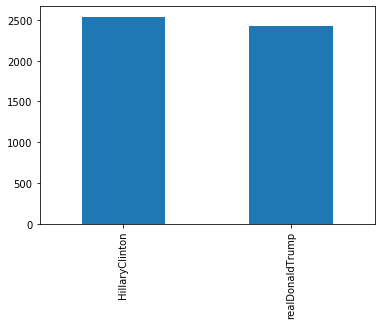

In [20]:
#Plottiamo il grafico dei tweet per etichetta
from matplotlib import pyplot as plt
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

Il programma è tarato per creare dataset quasi equilibrati. Se non lo sono, evidentemente c'è qualche problema nel mining dei tweet. Per esempio, ho personalmente avuto alcuni problemi nel minare alcuni account (tipo quello di Trump). Un problema ricorrente è il fatto che, per alcuni account, non è possibile scaricare oltre un certo numero di Tweet (perchè molti tweet vengono scartati in quanto tweet di risposta o retweet).

Nella fattispecie, volendo evitare problemi nei nostri test e scarse performance, per Trump ho provveduto a creare un file ad-hoc nella directory 'DataBackup' con un numero ragionevole di tweet (~2500).

Training Set


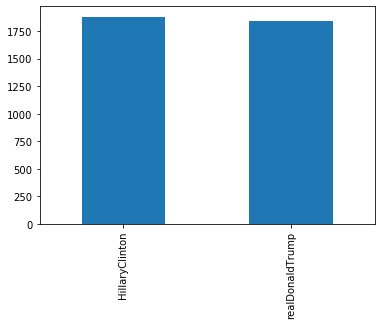

Test Set


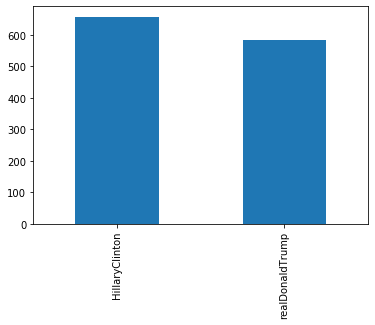

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

print("Training Set")
pd.Series(y_train_set).value_counts().plot.bar()
plt.show()

print("Test Set")
pd.Series(y_test_set).value_counts().plot.bar()
plt.show()

# Verso la classificazione
---

Ora creiamo il classificatore. Useremo come primo esempio un classificatore basato su **regressori logistici**. Useremo le classi **CountVectorizer** e **TfidfTransformer** per creare una rappresentazione vettoriale di ogni tweet e associare ad ogni feature di ciascuna rappresentazione un valore normalizzato con tf-idf.

**CountVectorizer** inoltre applicherà parti della NLP pipeline. In particolare farà:

1. Tokenization
- Eliminazione delle stop words (grazie al parametro max_df e al modulo stop_words)
- Lowercase delle parole

Per installare il modulo **stop_words** usa uno dei seguenti comandi:
1. pip install stop_words
- conda install -c conda-forge stop_words

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from stop_words import get_stop_words 

eng_stop_words = get_stop_words('english')
ita_stop_words = get_stop_words('italian')
list_stop_words = eng_stop_words + ita_stop_words

count_vect = CountVectorizer(ngram_range=(1,4), max_features=20000, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer(use_idf=True)
log = LogisticRegression(solver='liblinear')

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

print(log.fit(x_train, y_train_set))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [23]:
y_train_preds = log.predict(x_train)
y_test_preds = log.predict(x_test)

## Valutiamo il funzionamento del classificatore
---

Useremo l'F1 Score per valutare il comportamento del nostro classificatore sia sul test set che nel training set.

In [24]:
from sklearn.metrics import f1_score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))


F1 training scores: 0.96
F1 test scores: 0.91


I punteggi sono abbastanza alti per entrambi i set di dati. Ciò indica che il classificatore ha una capacità ottimale e non sta andando né in overfitting né in underfitting.

## Parole più pesate per etichetta
---

Utilizzando il modulo **eli5** mostreremo adesso come vengono pesate le diverse parole per i tweet dei due utenti presenti sul dataset.

Per installare **eli5** puoi usare uno dei seguenti comandi:
1. pip install eli5
- conda install -c conda-forge eli5

In [25]:
import eli5
display(eli5.show_weights(log, vec=count_vect, top=40,target_names=log.classes_))

Weight?,Feature
+3.984,russia
+3.826,democrats
+3.564,collusion
+3.539,mueller
+3.458,great
+3.317,impeachment
+3.138,witch
+3.055,witch hunt
+3.055,hunt
+2.932,hoax


Nel caso con due etichette, viene stampata un'unica colonna che indica per l'etichetta menzionata come vengono valutati i termini che gli si passano. Le parole (o i gruppi di parole) nella parte verde sono quelle che più identificano Trump, mentre quelle nella parte rossa della tabella identificano la Clinton.



## Controlliamo la probabilità predetta di un tweet scelto a random di Hillary e Trump
---

Vedremo degli esempi sulle probabilità predette dal nostro algoritmo sia per Trump che per Hillary.

Il primo esempio consisterà nel valutare due tweet che non conosce. Successivamente useremo il nostro classificatore sul dataset.

In [26]:
estimator = LogisticRegression(solver='liblinear',penalty='l2',C=1.0)
estimator.fit(x_train,y_train_set)

# Prepariamo il nostro test come vettori TfIdf, dove il primo sarebbe un Tweet più simile a ciò che scrive la Clinton
# mentre il secondo è un Tweet che non ci sorprenderebbe scrivesse Trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!"
]

###
# NOTA:  Non rinizializzare il tfidf vectorizor o lo spazio delle feature verrà sovrascritto e
# la nuova trasformazione potrebbe non coincidere con il numero di feature con il quale il nostro modello è stato allenato.
####

source_test = cleanTweet(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)
print(source_test)

display(pd.DataFrame(estimator.predict_proba(unknown_tweets_counts), columns=estimator.classes_))

['The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.', 'Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!']


,HillaryClinton,realDonaldTrump
0,0.9999,0.0001
1,0.1444,0.8556


In base al modello, la probabilità che il primo tweet sia di Hillary è del'99%! La probabilità che il secondo provenga da Trump è quasi del 80%. Il modello sembrerebbe funzionare in maniera corretta.

In [27]:
import eli5
display(eli5.show_prediction(estimator, doc=source_test[0], vec=count_vect, top=40,target_names=log.classes_))
display(eli5.show_prediction(estimator, doc=source_test[1], vec=count_vect, top=40,target_names=log.classes_))

## Adesso proverò ad estrarre i tweet presenti nel dataset che hanno la probabilità predetta più alta e più bassa con autore Trump o Hillary in base al nostro modello.
---
**Lo farò in 4 passi:**
1. Usando il metodo Predict Proba per avere un array delle probabilità dei Tweet di Hillary e Trump
- Trasformare quest'array in un DataFrame
- Unire il Dataset con questo DataFrame
- Stampare il Tweet più probabile e il meno probabile di entrambi

In [28]:
Probas_x = pd.DataFrame(estimator.predict_proba(x_train), columns=estimator.classes_)

In [29]:
joined_x = pd.merge(dataset, Probas_x, left_index=True, right_index=True)

In [30]:
joined_x

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.0678,0.9322
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,0.1331,0.8669
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.6642,0.3358
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.0802,0.9198
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.2519,0.7481
...,...,...,...,...,...,...,...,...
3716,1216347531321446400,realDonaldTrump,20851,Congratulations to the Great State of Tennesse...,2020-02-21 18:10:54.088438,Sun Jan 12 13:13:44 +0000 2020,0.7102,0.2898
3717,309,realDonaldTrump,20857,Just got back only to hear of a last minute ch...,2020-02-22 01:07:58.785460,07-23-2019 23:32:21,0.2105,0.7895
3718,1210568154658803713,realDonaldTrump,20884,Speaker Pelosi and Chuck Schumer’s drive to tr...,2020-02-21 18:10:55.446675,Fri Dec 27 14:28:33 +0000 2019,0.9933,0.0067
3719,874284812193935360,HillaryClinton,20889,My heart is with the loved ones of the 49 peop...,2020-02-21 17:05:25.690788,Mon Jun 12 15:18:37 +0000 2017,0.8946,0.1054


**Dei tweet scritti da Hillary Clinton, il tweet più probabile e il meno probabile (secondo la predizione del nostro software) sono:**

In [31]:
joined_hillary = joined_x[joined_x['handle']=="HillaryClinton"]
for el in joined_hillary[joined_hillary['HillaryClinton']==max(joined_hillary['HillaryClinton'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(max(joined_hillary['HillaryClinton'])))

Thirty-five days until the election. Have your friends and family checked their voter registration yet? Give them a nudge to do it today. Deadlines are approaching quickly. https://t.co/tTgeqxNqYm
Probabilità: 0.99


In [32]:
for el in joined_hillary[joined_hillary['HillaryClinton']==min(joined_hillary['HillaryClinton'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(min(joined_hillary['HillaryClinton'])))

@KatieS @MoxxieVentures This is exciting, Katie. Congratulations—and love the name!
Probabilità: 0.01


**Dei tweet scritti da Donald Trump, il tweet più probabile e il meno probabile (secondo la predizione del nostro software) sono:**

In [33]:
joined_donald = joined_x[joined_x['handle']=="realDonaldTrump"]
for el in joined_donald[joined_donald['realDonaldTrump']==max(joined_donald['realDonaldTrump'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(max(joined_donald['realDonaldTrump'])))

....BUT MAYBE I STILL WILL. WITCH HUNT!
Probabilità: 0.99


In [34]:
for el in joined_donald[joined_donald['realDonaldTrump']==min(joined_donald['realDonaldTrump'])]['text']:
    print(el)
    break
print("Probabilità: {:0.2f}".format(min(joined_donald['realDonaldTrump'])))

Speaker Pelosi and Chuck Schumer’s drive to try and rig the trial against the President is misplaced. There is no factual basis for the Articles of Impeachment that passed the House. This President will be exonerated.” William McGinley  @foxandfriends
Probabilità: 0.01


# Classificare con più di 2 etichette
---

Provvederemo ora un classificatore (sempre basato su regressione logistica) che ci permetterà di classificare anche i tweet di una terza persona. Nel nostro caso sceglieremo i tweet di Barack Obama.

In [35]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'
obama = 'BarackObama'

In [36]:
obama = 'BarackObama'
try:
    obama_df = pd.read_csv('../Data/{}.csv'.format(obama))
    notExists = False
except:
    notExists = True
    
ans = ''

if notExists == False:
    while True:
        ans = input("Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] ")
        if(ans == 's' or ans == 'n'):
            break

if ans == 's' or notExists == True:
    obama_tweets = miner.mine_user_tweets(user=obama)
    obama_df = pd.DataFrame(obama_tweets)
    obama_df.to_csv('../Data/{}.csv'.format(obama))
    print("Dati sovrascritti nel percorso '../Data/{}.csv!'".format(obama))
else:
    print("Useremo i dati contenuti nel file salvato precedentemente!")

Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] n
Useremo i dati contenuti nel file salvato precedentemente!


## Creiamo il dataset con i tweet di Obama
---

In questa fase quindi ripercuoteremo alcuni passi già visti:
1. Concateneremo i tre dataframe di tweet
- Ripuliremo i tweet
- Creiamo il Training set e il Test set

Triset


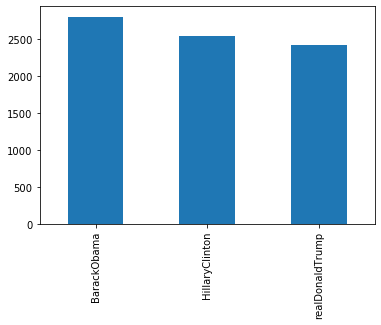

Training Set


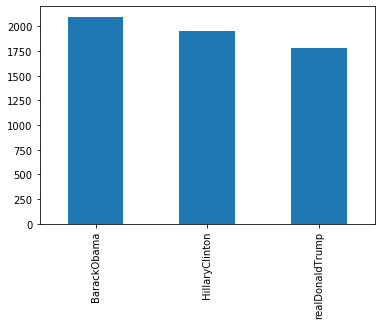

Test Set


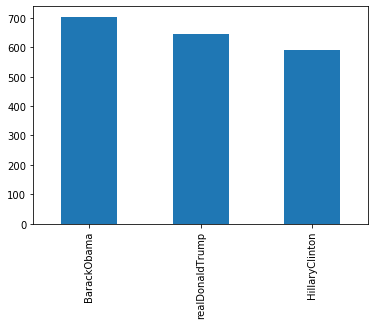

In [37]:
# Creiamo il "triset"
hillary_df = pd.read_csv('../Data/{}.csv'.format(hillary))
trump_df = pd.read_csv('../Data/{}.csv'.format(trump))
obama_df = pd.read_csv('../Data/{}.csv'.format(obama))
triset = pd.concat([hillary_df,trump_df,obama_df], axis=0)
triset = triset.sort_values(by='retweet_count')
triset = triset.drop(columns=['Unnamed: 0'])
triset = triset.reset_index(drop=True)

#Preprocessiamo i tweet
tweet_text = triset['text'].values
clean_text = cleanTweet(tweet_text)

#Associamo le etichette ai tweet
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = triset['handle'].values

#Stampiamo le etichette per vedere la distribuzione dei dati nel nostro triset
from matplotlib import pyplot as plt
print("Triset")
pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

#Creiamo Training e Test set
from sklearn.model_selection import train_test_split

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

print("Training Set")
pd.Series(y_train_set).value_counts().plot.bar()
plt.show()

print("Test Set")
pd.Series(y_test_set).value_counts().plot.bar()
plt.show()

## Verso la classificazione

Per poterla fare non potremo usare il metodo usato prima. Dovremo infatti usare delle tecniche più specifiche per gestire la presenza di più etichette. Nel nostro caso useremo la tecnica denominata **one vs all**. Possiamo raggiungere questo scopo indicando esplicitamente nell'istanziazione del Regressore Logistico il valore **ovr** al parametro **multi_class**.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(ngram_range=(1,4), max_features=20000, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer()
log = LogisticRegression(solver='liblinear', multi_class='ovr')

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)
    
x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

print(log.fit(x_train, y_train_set))

#Effettiamo il training e il test
y_train_preds = log.predict(x_train)
y_test_preds = log.predict(x_test)

#Stampiamo i valori dello score F1 per misurare le prestazioni
from sklearn.metrics import f1_score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
F1 training scores: 0.94
F1 test scores: 0.87


In [39]:
import eli5
display(eli5.show_weights(log, vec=count_vect, top=20,target_names=log.classes_))

## Effettuiamo un test di predizione di tweet non conosciuti

In [40]:
estimator = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, multi_class='ovr')
estimator.fit(x_train,y_train_set)

# Prepariamo il nostro test come vettori TfIdf, dove il primo sarebbe un Tweet più simile a ciò che scrive la Clinton
# mentre il secondo è un Tweet che non ci sorprenderebbe scrivesse Trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!",
    "Here are a couple of articles that are worth reading — from housing to health, these stories use data to explore challenges we face and demonstrate how policy solutions along with civic engagement can make a real difference in people’s lives."
]

###
# NOTA:  Non rinizializzare il tfidf vectorizor o lo spazio delle feature verrà sovrascritto e
# la nuova trasformazione potrebbe non coincidere con il numero di feature con il quale il nostro modello è stato allenato.
####

source_test = cleanTweet(source_test)

source_test = cleanTweet(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)

pd.DataFrame(log.predict_proba(unknown_tweets), columns=estimator.classes_)

,BarackObama,HillaryClinton,realDonaldTrump
0,0.0918,0.8464,0.0619
1,0.0687,0.2534,0.6779
2,0.3989,0.4779,0.1232


In [41]:
import eli5
display(eli5.show_prediction(estimator, doc=source_test[0], vec=count_vect, top=5,target_names=log.classes_))
display(eli5.show_prediction(estimator, doc=source_test[1], vec=count_vect, top=5,target_names=log.classes_))
display(eli5.show_prediction(estimator, doc=source_test[2], vec=count_vect, top=5,target_names=log.classes_))

## Ora controlliamo come si comporta sul nostro triset

In [42]:
Probas_x = pd.DataFrame(estimator.predict_proba(x_train), columns=estimator.classes_)
joined_x = pd.merge(triset, Probas_x, left_index=True, right_index=True)

In [43]:
joined_x[joined_x['handle']=='BarackObama']

,tweet_id,handle,retweet_count,text,mined_at,created_at,BarackObama,HillaryClinton,realDonaldTrump
15,533307135006760961,BarackObama,163,"CHIP IN NOW: Get your impact doubled now, befo...",2020-02-26 16:11:21.320593,Fri Nov 14 17:15:04 +0000 2014,0.0819,0.5945,0.3235
16,663836262676234240,BarackObama,164,LIVE: President Obama is speaking to @OFA volu...,2020-02-26 16:11:16.656340,Mon Nov 09 21:51:13 +0000 2015,0.1039,0.7545,0.1416
19,654315653671727104,BarackObama,183,Read why @GovEdRendell thinks #TPP will be goo...,2020-02-26 16:11:16.938606,Wed Oct 14 15:19:43 +0000 2015,0.8199,0.1332,0.0470
22,663836997404991489,BarackObama,191,"""It's always good to be with OFA. It's a littl...",2020-02-26 16:11:16.656340,Mon Nov 09 21:54:08 +0000 2015,0.4595,0.4089,0.1316
23,532293470799417344,BarackObama,191,Watch: This is what you should know about @OFA...,2020-02-26 16:11:21.322595,Tue Nov 11 22:07:07 +0000 2014,0.0979,0.7935,0.1086
...,...,...,...,...,...,...,...,...,...
5689,741373595306360832,BarackObama,16477,"""Minds open. Hearts change. America shifts."" —...",2020-02-26 16:11:14.227129,Fri Jun 10 20:56:53 +0000 2016,0.4290,0.4450,0.1260
5742,723241770411122688,BarackObama,16778,"""'A strong spirit transcends rules,' Prince on...",2020-02-26 16:11:14.783644,Thu Apr 21 20:07:29 +0000 2016,0.3146,0.3630,0.3225
5776,1130546280286117890,BarackObama,17065,Here’s a great story: While we’ve still got a ...,2020-02-26 16:11:12.219311,Mon May 20 18:50:12 +0000 2019,0.0641,0.0531,0.8828
5794,1151621137979383808,BarackObama,17203,I have a good feeling about these Chicago @Urb...,2020-02-26 16:11:11.760884,Wed Jul 17 22:34:10 +0000 2019,0.1151,0.1641,0.7207


# Classificare usando KNN
---

Abbiamo visto come si comporta il nostro classificatore basato su regressione logistica. Ora proveremo ad usare un approccio differente utilizzando l'algoritmo KNN. Spiegheremo in breve cosa fare per utilizzarlo e come il programma lo utilizza.

---

Prima di tutto ricreiamo il dataset e suddividiamo i dati in training, validation e test set. Il validation set ci servirà per effettuare la ricerca degli iperparametri. Nel nostro caso K è un iperparametro e diremo successivamente come lo valuteremo.

Dataset


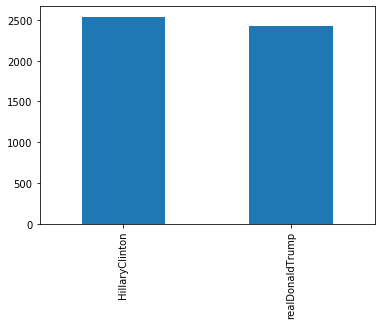

In [44]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

# Creiamo il dataset
hillary_df = pd.read_csv('../Data/{}.csv'.format(hillary))
trump_df = pd.read_csv('../Data/{}.csv'.format(trump))
dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)

#Preprocessiamo i tweet
tweet_text = dataset['text'].values
clean_text = cleanTweet(tweet_text)

#Associamo le etichette ai tweet
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

#Stampiamo le etichette per vedere la distribuzione dei dati nel nostro dataset
from matplotlib import pyplot as plt
print("Dataset")
pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

#Creiamo Training e Test set
from sklearn.model_selection import train_test_split

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)



#Del 75% userò il 33% per la validazione
train_set, vali_set, y_train_set, y_vali_set  = train_test_split(train_set,y_train_set, test_size=0.33)

## Esercitiamo il nostro classificatore
---

Dovremo inoltre indicare un valore K che massimizzi le misure di performance del nostro algoritmo. In particolare utilizzeremo un ciclo per trovare il valore K più performante misurando la performance del classificatore sul validation set.

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

count_vect = CountVectorizer(ngram_range=(1,4), max_features=750, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer()

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)
    
x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

x_vali_counts = count_vect.transform(vali_set)
x_vali = tfidf.transform(x_vali_counts)

best_score = 0
best_k = 0

for k_value in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k_value)
    knn.fit(x_train, y_train_set)
    y_vali_preds = knn.predict(x_vali)
    print("{} - F1 Validation Score: {:0.2f}".format(k_value,f1_score(y_vali_set,y_vali_preds,average='weighted')))
    if f1_score(y_vali_set,y_vali_preds,average='weighted') > best_score:
        best_score = f1_score(y_vali_set,y_vali_preds,average='weighted')
        best_k = k_value

print("Il miglior K è {}.".format(best_k))
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train_set)

#Effettiamo il training e il test
y_train_preds = knn.predict(x_train)
y_test_preds = knn.predict(x_test)

#Calcoliamo lo score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))

1 - F1 Validation Score: 0.60
2 - F1 Validation Score: 0.60
3 - F1 Validation Score: 0.49
4 - F1 Validation Score: 0.54
5 - F1 Validation Score: 0.48
6 - F1 Validation Score: 0.51
7 - F1 Validation Score: 0.45
8 - F1 Validation Score: 0.46
9 - F1 Validation Score: 0.41
10 - F1 Validation Score: 0.43
Il miglior K è 1.
F1 training scores: 0.99
F1 test scores: 0.62


In [46]:
# Prepariamo il nostro test come vettori TfIdf, dove il primo sarebbe un Tweet più simile a ciò che scrive la Clinton
# mentre il secondo è un Tweet che non ci sorprenderebbe scrivesse Trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!",
]

###
# NOTA:  Non rinizializzare il tfidf vectorizor o lo spazio delle feature verrà sovrascritto e
# la nuova trasformazione potrebbe non coincidere con il numero di feature con il quale il nostro modello è stato allenato.
####

source_test = cleanTweet(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)

pd.DataFrame(knn.predict_proba(unknown_tweets), columns=knn.classes_)

,HillaryClinton,realDonaldTrump
0,1.0,0.0
1,0.0,1.0


In [47]:
Probas_x = pd.DataFrame(knn.predict_proba(x_train), columns=knn.classes_)
joined_x = pd.merge(dataset, Probas_x, left_index=True, right_index=True)

In [48]:
joined_x

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.0,1.0
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,1.0,0.0
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.0,1.0
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.0,1.0
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.0,1.0
...,...,...,...,...,...,...,...,...
2488,22,realDonaldTrump,11413,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-22 01:07:58.785460,02-09-2020 00:07:31,0.0,1.0
2489,1226296531113955331,realDonaldTrump,11414,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-21 18:10:49.166956,Sun Feb 09 00:07:31 +0000 2020,0.0,1.0
2490,1219430494460268544,realDonaldTrump,11414,Texas Rep Roger Williams (@RepRWilliams) has d...,2020-02-21 18:10:52.524014,Tue Jan 21 01:24:20 +0000 2020,0.0,1.0
2491,1198688960207298562,realDonaldTrump,11436,Witch Hunt! https://t.co/CvZtyHMsGo,2020-02-21 18:10:59.093486,Sun Nov 24 19:44:53 +0000 2019,0.0,1.0


In [49]:
joined_x[joined_x['handle']=='realDonaldTrump']

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.0,1.0
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.0,1.0
6,1068,realDonaldTrump,41,I hear by demand a second investigation after ...,2020-02-22 01:07:58.785460,03-03-2017 20:47:30,0.0,1.0
142,85,realDonaldTrump,554,....What right does Crazy Nancy have to hold u...,2020-02-22 01:07:58.785460,12-23-2019 22:09:32,1.0,0.0
314,804,realDonaldTrump,809,“Trump recognized Russian Meddling MANY TIMES....,2020-02-22 01:07:58.785460,07-19-2018 13:27:03,1.0,0.0
...,...,...,...,...,...,...,...,...
2488,22,realDonaldTrump,11413,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-22 01:07:58.785460,02-09-2020 00:07:31,0.0,1.0
2489,1226296531113955331,realDonaldTrump,11414,Great lineup on @FoxNews tonight with @JesseBW...,2020-02-21 18:10:49.166956,Sun Feb 09 00:07:31 +0000 2020,0.0,1.0
2490,1219430494460268544,realDonaldTrump,11414,Texas Rep Roger Williams (@RepRWilliams) has d...,2020-02-21 18:10:52.524014,Tue Jan 21 01:24:20 +0000 2020,0.0,1.0
2491,1198688960207298562,realDonaldTrump,11436,Witch Hunt! https://t.co/CvZtyHMsGo,2020-02-21 18:10:59.093486,Sun Nov 24 19:44:53 +0000 2019,0.0,1.0


In [50]:
joined_x[joined_x['handle']=='HillaryClinton']

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,1.0,0.0
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.0,1.0
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.0,1.0
5,1209550097152913409,HillaryClinton,17,"@KatieS @MoxxieVentures This is exciting, Kati...",2020-02-21 17:05:22.423803,Tue Dec 24 19:03:10 +0000 2019,1.0,0.0
7,1029367764354576384,HillaryClinton,68,@itsmebeccam @TATLGDoc I’m so proud of you Reb...,2020-02-21 17:05:24.849021,Tue Aug 14 14:02:54 +0000 2018,1.0,0.0
...,...,...,...,...,...,...,...,...
2462,781869512983515136,HillaryClinton,11144,What kind of man stays up all night to smear a...,2020-02-21 17:05:27.922820,Fri Sep 30 14:53:12 +0000 2016,1.0,0.0
2466,1209519768748929024,HillaryClinton,11165,"A merry Christmas to all, and to all a good ni...",2020-02-21 17:05:22.423803,Tue Dec 24 17:02:39 +0000 2019,1.0,0.0
2467,859386649125548032,HillaryClinton,11194,Watch &amp; prepare to tear up. Thanks @jimmyk...,2020-02-21 17:05:25.690788,Tue May 02 12:38:38 +0000 2017,1.0,0.0
2468,796143289971994624,HillaryClinton,11229,"Remember, if you are in line before polls clos...",2020-02-21 17:05:25.690788,Wed Nov 09 00:12:06 +0000 2016,1.0,0.0


# Classificare usando MultinomialNB
---

Concludiamo la sezione dei classificatori parlando del classificatore Naive Bayes Multinomiale. Anche per questo vedremo come implementarlo e daremo dell informazioni qual'ora fosse necessario.

Dataset


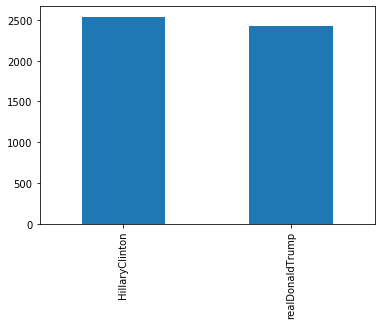

In [51]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

# Creiamo il dataset
hillary_df = pd.read_csv('../Data/{}.csv'.format(hillary))
trump_df = pd.read_csv('../Data/{}.csv'.format(trump))
dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)

#Preprocessiamo i tweet
tweet_text = dataset['text'].values
clean_text = cleanTweet(tweet_text)

#Associamo le etichette ai tweet
clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

#Stampiamo le etichette per vedere la distribuzione dei dati nel nostro dataset
from matplotlib import pyplot as plt
print("Dataset")
pd.Series(clean_df['label']).value_counts().plot.bar()
plt.show()

#Creiamo Training e Test set
from sklearn.model_selection import train_test_split

np.random.seed(1234)
#Userò il 25% dei dati del dataset come test_set
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

count_vect = CountVectorizer(ngram_range=(1,4), max_features=20000, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
tfidf = TfidfTransformer()

x_train_counts = count_vect.fit_transform(train_set)
x_train = tfidf.fit_transform(x_train_counts)
    
x_test_counts = count_vect.transform(test_set)
x_test = tfidf.transform(x_test_counts)

nb = MultinomialNB()
nb.fit(x_train, y_train_set)

#Effettiamo il training e il test
y_train_preds = nb.predict(x_train)
y_test_preds = nb.predict(x_test)

#Calcoliamo lo score
print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))

F1 training scores: 0.95
F1 test scores: 0.92


In [53]:
# Prepariamo il nostro test come vettori TfIdf, dove il primo sarebbe un Tweet più simile a ciò che scrive la Clinton
# mentre il secondo è un Tweet che non ci sorprenderebbe scrivesse Trump
source_test = [
    "The presidency doesn’t change who you are—it reveals who you are. And we’ve seen all we need to of Donald Trump.",
    "Crooked Hillary is spending tremendous amounts of Wall Street money on false ads against me. She is a very dishonest person!",
]

###
# NOTA:  Non rinizializzare il tfidf vectorizor o lo spazio delle feature verrà sovrascritto e
# la nuova trasformazione potrebbe non coincidere con il numero di feature con il quale il nostro modello è stato allenato.
####

source_test = cleanTweet(source_test)

unknown_tweets_counts = count_vect.transform(source_test)
unknown_tweets = tfidf.transform(unknown_tweets_counts)

pd.DataFrame(nb.predict_proba(unknown_tweets), columns=nb.classes_)

,HillaryClinton,realDonaldTrump
0,0.8768,0.1232
1,0.0536,0.9464


In [54]:
Probas_x = pd.DataFrame(nb.predict_proba(x_train), columns=nb.classes_)
joined_x = pd.merge(dataset, Probas_x, left_index=True, right_index=True)

In [55]:
joined_x

,tweet_id,handle,retweet_count,text,mined_at,created_at,HillaryClinton,realDonaldTrump
0,1077,realDonaldTrump,2,I don't know Putin have no deals in Russia and...,2020-02-22 01:07:58.785460,02-07-2017 12:04:01,0.0109,0.9891
1,1110610159188041729,HillaryClinton,9,"@mintimm @kenscudder Congratulations x2, Mini!...",2020-02-21 17:05:23.728000,Tue Mar 26 18:31:10 +0000 2019,0.0321,0.9679
2,1067,realDonaldTrump,11,I hearby demand a second investigation after S...,2020-02-22 01:07:58.785460,03-03-2017 20:49:53,0.6740,0.3260
3,1133369001617350656,HillaryClinton,11,@Hasbro Thank you. 🙏,2020-02-21 17:05:23.299601,Tue May 28 13:46:41 +0000 2019,0.0095,0.9905
4,1067988841431277569,HillaryClinton,15,@tarabea80 @BillClinton What kind words Tara. ...,2020-02-21 17:05:24.074316,Thu Nov 29 03:49:16 +0000 2018,0.0777,0.9223
...,...,...,...,...,...,...,...,...
3716,1216347531321446400,realDonaldTrump,20851,Congratulations to the Great State of Tennesse...,2020-02-21 18:10:54.088438,Sun Jan 12 13:13:44 +0000 2020,0.8804,0.1196
3717,309,realDonaldTrump,20857,Just got back only to hear of a last minute ch...,2020-02-22 01:07:58.785460,07-23-2019 23:32:21,0.0619,0.9381
3718,1210568154658803713,realDonaldTrump,20884,Speaker Pelosi and Chuck Schumer’s drive to tr...,2020-02-21 18:10:55.446675,Fri Dec 27 14:28:33 +0000 2019,0.8464,0.1536
3719,874284812193935360,HillaryClinton,20889,My heart is with the loved ones of the 49 peop...,2020-02-21 17:05:25.690788,Mon Jun 12 15:18:37 +0000 2017,0.9382,0.0618


# Confronto delle prestazioni
---

Valuteremo ora l'operato dei vari classificatori con vari settaggi e cercheremo di trarre delle conclusioni.

Valutiamo prima di tutto l'operato dei classificatori usando due etichette.

In [56]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'

hillary_df = pd.read_csv('../Data/{}.csv'.format(hillary))
trump_df = pd.read_csv('../Data/{}.csv'.format(trump))
dataset = pd.concat([hillary_df, trump_df], axis=0)
dataset = dataset.sort_values(by='retweet_count')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.reset_index(drop=True)

tweet_text = dataset['text'].values
clean_text = cleanTweet(tweet_text)

clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = dataset['handle'].values

from sklearn.model_selection import train_test_split

np.random.seed(1234)
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

scores = pd.DataFrame(['Classificatore', 'F1'])

## Regressore Logistico

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    log = LogisticRegression(solver='liblinear')   

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)
    
    log.fit(x_train, y_train_set)

    y_train_preds = log.predict(x_train)
    y_test_preds = log.predict(x_test)

    """
    print("#features: {}\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_score = pd.Series({'F1':f1_score(y_train_set,y_train_preds,average='weighted')},name='LOG_REG TR features:{}'.format(750*2**i))
    scores = scores.append(new_score)
    new_score = pd.Series({'F1':f1_score(y_test_set,y_test_preds,average='weighted')},name='LOG_REG TE features:{}'.format(750*2**i))
    scores = scores.append(new_score)

## KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    knn = KNeighborsClassifier(n_neighbors=3)

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    knn.fit(x_train, y_train_set)

    y_train_preds = knn.predict(x_train)
    y_test_preds = knn.predict(x_test)

    """
    print("#features: {} - k = 3\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_score = pd.Series({'F1':f1_score(y_train_set,y_train_preds,average='weighted')},name='KNN TR features:{}'.format(750*2**i))
    scores = scores.append(new_score)
    new_score = pd.Series({'F1':f1_score(y_test_set,y_test_preds,average='weighted')},name='KNN TE features:{}'.format(750*2**i))
    scores = scores.append(new_score)

## Multinomial Naive Bayes

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    nb = MultinomialNB()
    nb.fit(x_train, y_train_set)

    y_train_preds = nb.predict(x_train)
    y_test_preds = nb.predict(x_test)
    
    """
    print("#features: {}\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_score = pd.Series({'F1':f1_score(y_train_set,y_train_preds,average='weighted')},name='MNB TR features:{}'.format(750*2**i))
    scores = scores.append(new_score)
    new_score = pd.Series({'F1':f1_score(y_test_set,y_test_preds,average='weighted')},name='MNB TE features:{}'.format(750*2**i))
    scores = scores.append(new_score)

## Grafico degli Score

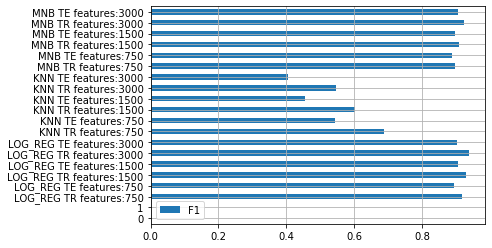

In [60]:
from matplotlib import pyplot as plt
scores.plot.barh()
plt.grid()
plt.show()

**Come possiamo notare** la regressione logistica e il classificatore multinomiale lavorano meglio all'aumentare del numero delle feature. KNN invece peggiora questo è derivato dal fatto che, aumentando la dimensionalità delle rappresentazioni, KNN ha prestazioni peggiori (https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction).

---

Facciamo un ultimo confronto valutando il comportamento dei classificatori (con gli stessi settaggi) su dataset con **3 etichette**.

In [61]:
trump = 'realDonaldTrump'
hillary = 'HillaryClinton'
obama = 'BarackObama'

hillary_df = pd.read_csv('../Data/{}.csv'.format(hillary))
trump_df = pd.read_csv('../Data/{}.csv'.format(trump))
obama_df = pd.read_csv('../Data/{}.csv'.format(obama))
triset = pd.concat([hillary_df,trump_df,obama_df], axis=0)
triset = triset.sort_values(by='retweet_count')
triset = triset.drop(columns=['Unnamed: 0'])
triset = triset.reset_index(drop=True)

tweet_text = triset['text'].values
clean_text = cleanTweet(tweet_text)

clean_df = pd.DataFrame(clean_text, columns=['x'])
clean_df['label'] = triset['handle'].map(lambda x: 0 if x == 'HillaryClinton' else 1 if x == 'realDonaldTrump' else 2).values

from sklearn.model_selection import train_test_split

np.random.seed(1234)
train_set, test_set, y_train_set, y_test_set  = train_test_split(clean_df['x'].tolist(),clean_df['label'].tolist(), test_size=0.25)

scores = pd.DataFrame(['Classificatore', 'F1'])


## Regressore Logistico

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    log = LogisticRegression(solver='liblinear', multi_class='ovr')   

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)
    
    log.fit(x_train, y_train_set)

    y_train_preds = log.predict(x_train)
    y_test_preds = log.predict(x_test)

    """
    print("#features: {}\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_score = pd.Series({'F1':f1_score(y_train_set,y_train_preds,average='weighted')},name='LOG_REG TR features:{}'.format(750*2**i))
    scores = scores.append(new_score)
    new_score = pd.Series({'F1':f1_score(y_test_set,y_test_preds,average='weighted')},name='LOG_REG TE features:{}'.format(750*2**i))
    scores = scores.append(new_score)

## KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()
    knn = KNeighborsClassifier(n_neighbors=3)

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    knn.fit(x_train, y_train_set)

    y_train_preds = knn.predict(x_train)
    y_test_preds = knn.predict(x_test)
    
    """
    print("#features: {} - k = 3\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_score = pd.Series({'F1':f1_score(y_train_set,y_train_preds,average='weighted')},name='KNN TR features:{}'.format(750*2**i))
    scores = scores.append(new_score)
    new_score = pd.Series({'F1':f1_score(y_test_set,y_test_preds,average='weighted')},name='KNN TE features:{}'.format(750*2**i))
    scores = scores.append(new_score)

## Multinomial Naive Bayes

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score

for i in range(3):
    count_vect = CountVectorizer(ngram_range=(1,4), max_features=750*2**i, max_df=0.7, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer()

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)

    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    nb = MultinomialNB()
    nb.fit(x_train, y_train_set)

    y_train_preds = nb.predict(x_train)
    y_test_preds = nb.predict(x_test)
    
    """
    print("#features: {}\n".format(750*2**i))
    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}\n".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    """
    new_score = pd.Series({'F1':f1_score(y_train_set,y_train_preds,average='weighted')},name='MNB TR features:{}'.format(750*2**i))
    scores = scores.append(new_score)
    new_score = pd.Series({'F1':f1_score(y_test_set,y_test_preds,average='weighted')},name='MNB TE features:{}'.format(750*2**i))
    scores = scores.append(new_score)

## Grafico degli Score

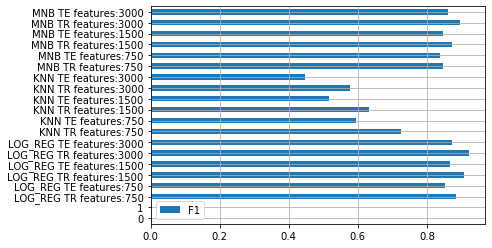

In [65]:
from matplotlib import pyplot as plt
scores.plot.barh()
plt.grid()
plt.show()

Non ci sorprende notare che le prestazioni sono generalmente calate per tutti gli algoritmi, in quanto questo dipende dal fatto che abbiamo aggiunto una nuova etichetta: ciò ha inserito maggiore incertezza.

---

**Abbiamo quindi** concluso la panoramica di ciò che può fare lo script. Daremo adesso il codice completo dello script.

---

# Chi lo ha detto: Sorgente

Dividerò il sorgente in più parti per permettere di modificare in corsa parti del programma (come il dataset, il numero di persone da cui prelevare i tweet, il tipo di classificatore...).

**SEZIONE DELLA PREDIZIONE DEI TWEET FORNITI E GENERAZIONE TABELLE DI PROBABILITA'**

In [66]:
def classify(clas, tfidf, vect, dataset, api):
    while True:
        dt = None
        print("\n\nSCEGLI COME PREFERISCI FORNIRE IL TWEET DA CLASSIFICARE")
        print("1) Inserimento Manuale")
        print("2) Download da Tweet indicando un utente")
        print("3) Tweet presente all'interno al Dataframe")
        print("4) Ritornare al menù principale")
        print("[Default: 3]")
        answer = input("La tua scelta: ")
        
        if answer == '1':
            dt = manualTweets()
        elif answer == '2':
            if api != None:
                dt = apiTweets(api)
            else:
                print("Non hai inizializzato le API. Opzione non disponibile!")
                continue
        elif answer == '4':
            return
        else:
            dt = datasetTweets(dataset)
        
        clean_tweets = cleanTweet(dt['text'].tolist())
        count_tweets = vect.transform(clean_tweets)
        tf_tweets = tfidf.transform(count_tweets)
        
        Probas_x = pd.DataFrame(clas.predict_proba(tf_tweets), columns = clas.classes_)
        joined_x = dt
        joined_x[clas.classes_] = Probas_x
        joined_x = joined_x.reset_index(drop=True)
        display(joined_x)
        
        for x in dt['text'].tolist():
            display(eli5.show_prediction(clas, doc=x, vec=vect, top=40,target_names=clas.classes_))
        

def manualTweets():
    tweets = []
    
    print("Quanti tweet vuoi inserire?\n[Max 10, Default 1]\n")
    answer = input("La tua scelta: ")
    if answer.isdigit():
        if int(answer) > 10 or int(answer) < 1:
            answer = 1
        else:
            answer = int(answer)
    else:
        answer = 1
    
    for a in range(answer):
        print("\nScrivi un tweet:")
        tweet = input("Il tuo tweet: ")
        tweets.append(tweet)
        
    dt = pd.DataFrame()
    dt['text'] = tweets
    dt['handle'] = "you"
    
    return dt    

def apiTweets(api):
    tweets = []
    handles = []
    
    print("Da quanti utenti vuoi scaricare il tweet?\n[Max 5, Default 1]")
    answer = input("La tua scelta: ")
    if answer.isdigit():
        if int(answer) > 5 or int(answer) < 1:
            answer = 1
        else:
            answer = int(answer)
    else:
        answer = 1
        
    for a in range(answer):
        while True:
            try:
                print("\nScrivi un username da cui scaricare il tweet:")
                user = input("La tua scelta: ")
                statuses = api.GetUserTimeline(screen_name=user, count=200, include_rts=False)
                statuses = [_.AsDict() for _ in statuses]
                break
            except:
                print("Utente non trovato. Riprovare!")
                
        for item in statuses:
            if checkLenTweet(item['full_text']):
                tweets.append(item['full_text'])
                handles.append(user)
                print("Aggiunto un tweet di {}.\nTesto:\"{}\"\n\n".format(user, item['full_text']))
                break;
    
    dt = pd.DataFrame()
    dt['text'] = tweets
    dt['handle'] = handles
    
    return dt

def datasetTweets(dataset):
    tweets = []
    handles = []
    
    print("Quanti tweet vuoi prelevare dal dataset?\n[Max 10, Default 1]")
    answer = input("La tua scelta: ")
    if answer.isdigit():
        if int(answer) > 10 or int(answer) < 1:
            answer = 1
        else:
            answer = int(answer)
    else:
        answer = 1
    
    for a in range(answer):
        print("\nScrivi il numero della riga del dataset da cui prendere il tweet\n[Max {}, Default 0]:".format(len(dataset)-1))
        answer = input("La tua scelta: ")
        if answer.isdigit():
            if int(answer) > (len(dataset)-1) or int(answer) < 0:
                answer = 0
            else:
                answer = int(answer)
        else:
            answer = 0
        tweets.append(dataset.at[answer, 'text'])
        handles.append(dataset.at[answer, 'handle'])
        print("Prelevato il tweet #{} di {}!\n".format(answer, dataset.at[answer, 'handle']))   
        
    dt = pd.DataFrame()
    dt['text'] = tweets
    dt['handle'] = handles
    
    return dt

**METODI DI SUPPORTO AL MINING E AD ALTRE OPERAZIONI VARIE**

In [67]:
def checkLenTweet(raw_data):
    data = txt.replace_urls(raw_data,"")
    data = txt.replace_emails(data,"")
    data = txt.replace_emojis(data,"")
    data = txt.replace_user_handles(data,"")
    data = txt.replace_phone_numbers(data,"")
    data = txt.replace_numbers(data,"")
    data = txt.replace_currency_symbols(data,"")
    data = txt.replace_hashtags(data,"")
    if len(data) < 28:
        return False
    else:
        return True

class TweetMiner(object):

    
    def __init__(self, api, result_limit = 100, max_tweets=3000): #result_limit è il numero di tweet che scaricheremo ad ogni interazione con le api di Twitter
        
        self.api = api        
        if result_limit < 200: #Non può essere più di 200. 
            self.result_limit = result_limit
        else:
            self.result_limit = 200
        self.max_tweets = max_tweets
        

    def mine_user_tweets(self, user="", mine_retweets=False, no_replies=False, max_pages=40):
        import datetime
        
        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while len(data) < self.max_tweets and page <= max_pages:   
            if last_tweet_id: #Serve per evitare che si riprendano dei tweet già letti. Inizializziamo max_id con un id più piccolo dell'ultimo minato.
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id-1, include_rts=mine_retweets, exclude_replies=no_replies)
                statuses = [ _.AsDict() for _ in statuses]
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, include_rts=mine_retweets, exclude_replies=no_replies)
                statuses = [_.AsDict() for _ in statuses]
                
            for item in statuses:
                # Si usa try except perchè quando retweets = 0 si riceve un errore (GetUserTimeline fallisce a creare una key, 'retweet_count')
                try:
                    mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   item['retweet_count'],
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                except:
                    mined = {
                        'tweet_id':        item['id'],
                        'handle':          item['user']['screen_name'],
                        'retweet_count':   0,
                        'text':            item['full_text'],
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item['created_at'],
                    }
                
                last_tweet_id = mined['tweet_id']
                if checkLenTweet(mined['text']):
                    data.append(mined)
            page += 1
            #print(len(data))
            
        return data
    
#ripuliamo i tweet usando textacy
def cleanTweet(raw_data):
    import textacy.preprocessing as txt
    data = [txt.replace_urls(x,"") for x in raw_data]
    data = [txt.replace_emails(x,"") for x in data]
    data = [txt.replace_emojis(x,"") for x in data]
    data = [txt.replace_user_handles(x,"") for x in data]
    data = [txt.replace_phone_numbers(x,"") for x in data]
    data = [txt.replace_numbers(x,"") for x in data]
    data = [txt.replace_currency_symbols(x,"") for x in data]
    data = [txt.replace_hashtags(x,"") for x in data]
    return data

#Gestisce l'accesso alle API di Twitter
def getAPI(ck, cs, atk, ats):
    
    ck = 'Tck3q8BKObFM3IspZC4ciF1l9'
    cs = 'iMcU8xUMsvAssYBL4wiOOi0kanqZzm7Kl41OGkBNeb86kMIxc0'
    atk = '717687265812721667-k1GQTWpwsH7VtEC6gKLwETgQz9otPNz'
    ats = 'bEITKPKgwMBomofe42oKWgUNc8dPeWGlfU8wS5XbM5tnj'
    
    twitter_keys = {
        'consumer_key':        ck,
        'consumer_secret':     cs,
        'access_token_key':    atk,
        'access_token_secret': ats
    }

    try:
        api = twitter.Api(
            consumer_key         =   twitter_keys['consumer_key'],
            consumer_secret      =   twitter_keys['consumer_secret'],
            access_token_key     =   twitter_keys['access_token_key'],
            access_token_secret  =   twitter_keys['access_token_secret'],
            tweet_mode = 'extended'
        )
        
        api.GetFriends() #Serve per far fallire in caso di non autenticazione
        print("API inizializzate con successo!")
        return api
    except Exception as e:
        print(e)
        print("Errore nell'accesso alle API! Riprovare!")
        return None

#Inizializza le API
def setAPI():
    print("\nINIZIALIZZA LE API. Ti chiederemo di fornire le chiavi di accesso alle API di TWITTER.\n")
    ck = input('consumer_key: ')
    cs = input('consumer_secret: ')
    atk = input('access_token_key: ')
    ats = input('access_token_secret: ')
    return getAPI(ck, cs, atk, ats)

#Crea la cartella da cui cercare i tweet
def makeData():
    import os
    print("\n\nCONTROLLO SE ESISTE LA CARTELLA DATA")
    try:
        os.mkdir('../Data')
        print("Cartella creata.")
    except:
        print("Cartella esistente.")

**SEZIONE MINING E DATASET**

In [68]:
#Implementa il mining dei tweet. Controlla se esiste un file .csv di quell'utente ed eventualmente chiede
#se sovrascrivere con una nuova ricerca di tweet
def mine_tweets(username,api,number_tweets=100):
    miner = TweetMiner(api, max_tweets=number_tweets)
    try:
        user_df = pd.read_csv('../Data/{}.csv'.format(username))
        notExists = False
    except:
        notExists = True

    ans = ''

    if notExists == False:
        while True:
            ans = input("Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] ")
            if(ans == 's' or ans == 'n'):
                break
    if api == None:
        if ans == 's':
            print("Non hai inizializzato le API. Opzione non disponibile!\nUseremo il file presente in memoria.")
            return 0, api, username
        
        if notExists == True:
            print("Non hai inizializzato le API. Opzione non disponibile!\nVuoi inizializzarle? (s,n) [Default n]\n")
            answer = input('La tua scelta: ')
            if answer == 's':
                api = setAPI()
                return mine_tweets(username,api)
            else:
                print("Se non puoi inizializzarle, ti consigliamo di usare i dati degli utenti presenti in memoria.")
                return 1, api, username

    if ans == 's' or notExists == True:
        try:
            user_tweets = miner.mine_user_tweets(user=username)
            username = user_tweets[0]['handle']
        except Exception as e:
            print(e)
            print("Username non valido! Riprovare con un altro username!")
            return 1, api, username
        user_df = pd.DataFrame(user_tweets)
        user_df.to_csv('../Data/{}.csv'.format(username))
        print("Dati sovrascritti nel percorso '../Data/{}.csv!'".format(username))
    else:
        print("Useremo i dati contenuti nel file salvato precedentemente!")
    return 0, api, username
    
#Stampa la lista dei dataframe salvati in memoria
def printDF():
    import os
    fileList = os.listdir("../Data")
    try:
        fileList =  [re.search('[A-Za-z]*[^.csv]', x).group(0) if x != '.csv' else '' for x in fileList]
    except Exception as e:
        print(e)
    print(fileList)
    
#Restituisce la lista dei dataframe salvati in memoria
def getDF():
    import os
    fileList = os.listdir("../Data")
    try:
        fileList =  [re.search('[A-Za-z]*[^.csv]', x).group(0) if x != '.csv' else '' for x in fileList]
    except Exception as e:
        print(e)
    return(fileList)

#Aggiunge un utente (se esiste) nel Dataset
def addUser(username,dataset):
    try:
        user_df = pd.read_csv('../Data/{}.csv'.format(username))
        dataset = pd.concat([dataset, user_df], axis=0, sort=True)
        dataset = dataset.sort_values(by='retweet_count')
        dataset = dataset.drop(columns=['Unnamed: 0'])
        dataset = dataset.reset_index(drop=True)
        print("Aggiunto l'utente {}!".format(username))
    except Exception as e:
        print("Errore nell'aggiunta dell'utente!")
        print(e)
        return dataset, 1
    return dataset, 0

#Rimuove un utente (se presente) dal Dataset
def dropUser(username,dataset):
    print("Rimosso l'utente {}!".format(username))
    dt = dataset[dataset['handle'] != username]
    dt = dt.reset_index(drop=True)
    return dt

#Mostra una sezione del Dataset
def printDataset(dataset, low_lim = 0, high_lim = 0, user = None):
    if high_lim <= low_lim:
        high_lim = len(dataset)-1        
    if user == None:
        display(dataset[low_lim:high_lim])
    else:
        display(dataset[dataset['handle'] == user])

**SEZIONE CLASSIFICATORI**

In [69]:
#Stampa i plot dei dati
def printPlot(dataset,s=''):
    print(s)
    ans = input("Stampare il plot dei dati? [s,n] Default n. ")
    if ans == 's':
        pd.Series(dataset).value_counts().plot.bar()
        plt.show()

#Applica preprocessing sul dataset
def clean(dataset):
    tweet_text = dataset['text'].values
    clean_text = cleanTweet(tweet_text)
    clean_df = pd.DataFrame(clean_text, columns=['x'])
    clean_df['label'] = dataset['handle'].values
    
    printPlot(clean_df['label'].tolist(),"Dataset")
    
    return clean_df

#Divide il dataset in TrS, TeS ed eventualmente VaS
def splitDataset(dataset,percent=0.25,knn=False,knn_percent=0.33):

    train_set, test_set, y_train_set, y_test_set  = train_test_split(dataset['x'].tolist(),dataset['label'].tolist(), test_size=percent)
    
    printPlot(y_train_set,'Training Set')
    
    if knn:
        train_set, vali_set, y_train_set, y_vali_set  = train_test_split(train_set,y_train_set, test_size=knn_percent)
        printPlot(y_vali_set,'Validation Set')
            
    printPlot(y_test_set,'Test Set')
    
    if knn:
        return train_set, y_train_set, test_set, y_test_set, vali_set, y_vali_set
    else:
        return train_set, y_train_set, test_set, y_test_set

#Regressore Logistico
def LRegr(dataset, num_label, features=20000, tdf=True):
    
    train_set, y_train_set, test_set, y_test_set = splitDataset(dataset)
    
    count_vect = CountVectorizer(ngram_range=N_GRAMS, max_features=features, max_df=STOP_WORDS_H, min_df=STOP_WORDS_L, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer(use_idf=tdf)

    
    if num_label > 2:
        log = LogisticRegression(solver='liblinear', multi_class='ovr')
    else:
        log = LogisticRegression(solver='liblinear')
        
    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)
    
    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    log.fit(x_train, y_train_set)

    y_train_preds = log.predict(x_train)
    y_test_preds = log.predict(x_test)

    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    
    return log, tfidf, count_vect

#KNN
def KNN(dataset, features=750, tdf=True, k=0):
    
    train_set, y_train_set, test_set, y_test_set, vali_set, y_vali_set = splitDataset(dataset, knn = True)
    
    count_vect = CountVectorizer(ngram_range=N_GRAMS, max_features=features, max_df=STOP_WORDS_H, min_df=STOP_WORDS_L, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer(use_idf=tdf)
    
    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)
    
    x_vali_counts = count_vect.transform(vali_set)
    x_vali = tfidf.transform(x_vali_counts)
    
    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)
      
    
    if k == 0:
        print("Valuteremo ora che K assegnare per massimizzare le performances.")
        best_score = 0
        best_k = 0

        for k_value in range(1,11):
            knn = KNeighborsClassifier(n_neighbors=k_value)
            knn.fit(x_train, y_train_set)
            y_vali_preds = knn.predict(x_vali)
            print("{} - F1 Validation Score: {:0.2f}".format(k_value,f1_score(y_vali_set,y_vali_preds,average='weighted')))
            if f1_score(y_vali_set,y_vali_preds,average='weighted') > best_score:
                best_score = f1_score(y_vali_set,y_vali_preds,average='weighted')
                best_k = k_value

        print("Il miglior K è {}.".format(best_k))
    else:
        k_value = k
        
    knn = KNeighborsClassifier(n_neighbors=k_value)

    knn.fit(x_train, y_train_set)

    y_train_preds = knn.predict(x_train)
    y_test_preds = knn.predict(x_test)

    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    return knn, tfidf, count_vect

#Multinomial Naive Bayes
def MNB(dataset, features=20000, tdf=True):
    
    train_set, y_train_set, test_set, y_test_set = splitDataset(dataset)
    
    count_vect = CountVectorizer(ngram_range=N_GRAMS, max_features=features, max_df=STOP_WORDS_H, min_df=STOP_WORDS_L, strip_accents='unicode', stop_words=list_stop_words)
    tfidf = TfidfTransformer(use_idf=tdf)

    x_train_counts = count_vect.fit_transform(train_set)
    x_train = tfidf.fit_transform(x_train_counts)
    
    x_test_counts = count_vect.transform(test_set)
    x_test = tfidf.transform(x_test_counts)

    nb = MultinomialNB()
    nb.fit(x_train, y_train_set)

    y_train_preds = nb.predict(x_train)
    y_test_preds = nb.predict(x_test)

    print("F1 training scores: {:0.2f}".format(f1_score(y_train_set,y_train_preds,average='weighted')))
    print("F1 test scores: {:0.2f}".format(f1_score(y_test_set,y_test_preds,average='weighted')))
    
    return nb, tfidf, count_vect

#Permette di scegliere tra i vari un classificatore
def chooseClassifier(dataset,num_label):
    answer = input("Indicare quale classificatore scegliere:\n1) Logistic Regressor\n2) Multinomial Naive Bayes\n3) KNN\nLa tua scelta è:[Default 1] ")
    
    if answer == '3':
        return KNN(clean(dataset))
    elif answer == '2':
        return MNB(clean(dataset))
    else:
        return LRegr(clean(dataset),num_label)

# SEZIONE MAIN
---

Il codice è strutturato per essere interagibile e modificabile a piacimento. Le sezioni sono studiate per essere eseguite in ordine. Il software potrebbe quindi funzionare in maniera non desiderata se non segui l'ordine indicato.

**LIBRERIE USATE**

In [70]:
"""LIBRERIE USATE"""

import pandas as pd
import twitter
import re
import eli5
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import textacy.preprocessing as txt
from sklearn.metrics import f1_score
from stop_words import get_stop_words 
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 3)
pd.set_option('expand_frame_repr', False)

eng_stop_words = get_stop_words('english')
ita_stop_words = get_stop_words('italian')
list_stop_words = eng_stop_words + ita_stop_words
STOP_WORDS_H = 0.7
STOP_WORDS_L = 0.0
N_GRAMS = (1,4)
api = None
dataset = None
users_in_dt = []
num_label = 0
classifier = tfidf = count_vect = None

makeData()



CONTROLLO SE ESISTE LA CARTELLA DATA
Cartella esistente.


# Inizializzare le API

In [235]:
api = setAPI()


INIZIALIZZA LE API. Ti chiederemo di fornire le chiavi di accesso alle API di TWITTER.

consumer_key: 
consumer_secret: 
access_token_key: 
access_token_secret: 
API inizializzate con successo!


# Mining di nuovi Tweet


In [236]:
username = input("Indica il nome dell'utente da cui minare i tweet: ")
err, api, username = mine_tweets(username,api,3000)
if err == 1:
    print("Errore! Riprovare!")

Indica il nome dell'utente da cui minare i tweet: luigidimaio
Trovato un file contenente i tweet dell'utente cercato. Vuoi sovrascrivere il contenuto di questo file? [s/n] s
Dati sovrascritti nel percorso '../Data/luigidimaio.csv!'


# Stampa lista degli elementi salvati in memoria

In [239]:
printDF()

['BarackObama', 'HillaryClinton', 'luigidimaio', 'matteosalvinimi', 'realDonaldTrump']


# Aggiungere Elementi al Dataset

In [241]:
username = input("Indica un utente da aggiungere:")
dataset, err = addUser(username,dataset)
if err == 1:
    print("Errore! Riprova!")
else:
    users_in_dt.append(username)
    num_label += 1

Indica un utente da aggiungere:matteosalvinimi
Aggiunto l'utente matteosalvinimi!


# Rimuovere Elementi dal Dataset

In [231]:
username = input("Indica un utente da rimuovere:")
if username in users_in_dt:
    dataset = dropUser(username,dataset)
    num_label = len(users_in_dt)
    users_in_dt.remove(username)
else:
    print("Utente non presente!")

Indica un utente da rimuovere:HillaryClinton
Rimosso l'utente HillaryClinton!


# Stampa le etichette presenti nel Dataset

In [242]:
print(users_in_dt)

['luigidimaio', 'matteosalvinimi']


Indicare quale classificatore scegliere:
1) Logistic Regressor
2) Multinomial Naive Bayes
3) KNN
La tua scelta è:[Default 1] 1
Dataset
Stampare il plot dei dati? [s,n] Default n. s


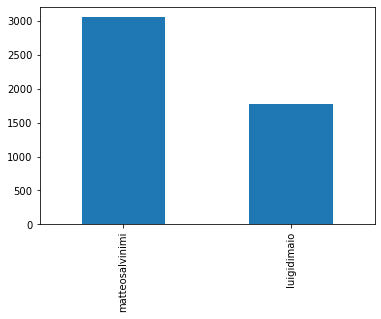

Training Set
Stampare il plot dei dati? [s,n] Default n. s


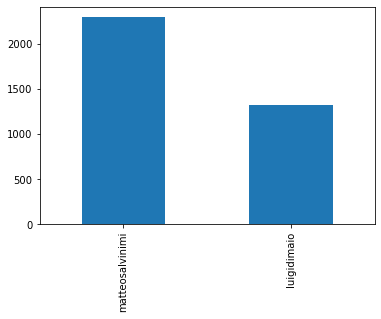

Test Set
Stampare il plot dei dati? [s,n] Default n. s


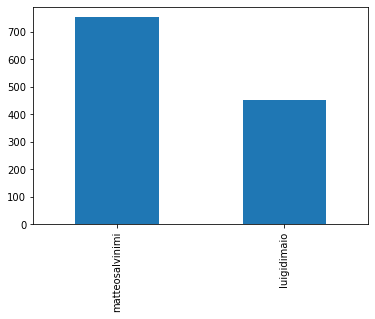

F1 training scores: 0.96
F1 test scores: 0.84


In [243]:
if num_label > 1:       
    classifier, tfidf, count_vect = chooseClassifier(dataset,num_label)
else:
    print("Devi avere caricato i tweet di almeno 2 utenti diversi.\nAttualmente ve ne sono: {}".format(num_label))

# Mostra la tabella delle feature con i relativi pesi

In [245]:
if classifier != None:
    display(eli5.show_weights(classifier, vec=count_vect, top=40,target_names=classifier.classes_))
else:
    print("Devi prima selezionare un classificatore!")

Weight?,Feature
+4.681,lega
+4.283,live
+4.206,amici
+4.161,26gennaiovotolega
+2.630,emilia
+2.318,romagna
+2.172,sinistra
+2.122,qualcuno
+2.119,emilia romagna
+2.109,conte


# Classifichiamo

In [258]:
if classifier != None and num_label > 1:
    classify(classifier, tfidf, count_vect, dataset, api)
elif classifier == None:
    print("Devi prima scegliere un classificatore!")
elif num_label < 2:
    print("Devi avere caricato i tweet di almeno 2 utenti diversi.\nAttualmente ve ne sono: {}".format(num_label))



SCEGLI COME PREFERISCI FORNIRE IL TWEET DA CLASSIFICARE
1) Inserimento Manuale
2) Download da Tweet indicando un utente
3) Tweet presente all'interno al Dataframe
4) Ritornare al menù principale
[Default: 3]
La tua scelta: 2
Da quanti utenti vuoi scaricare il tweet?
[Max 5, Default 1]
La tua scelta: 1

Scrivi un username da cui scaricare il tweet:
La tua scelta: realDonaldTrump
Aggiunto un tweet di realDonaldTrump.
Testo:".@RepKevinBrady (R) of Texas-08 loves Texas &amp; our Country. He has been a GREAT Congressman &amp; supporter of #MAGA. Strong on Crime, Border, Military, Vets and your 2A, he is the best Tax Cutter in D.C. Kevin has my Complete &amp; Total Endorsement. Vote on March 3rd. Thank you!"




,text,handle,luigidimaio,matteosalvinimi
0,.@RepKevinBrady (R) of Texas-08 loves Texas &a...,realDonaldTrump,0.412,0.588




SCEGLI COME PREFERISCI FORNIRE IL TWEET DA CLASSIFICARE
1) Inserimento Manuale
2) Download da Tweet indicando un utente
3) Tweet presente all'interno al Dataframe
4) Ritornare al menù principale
[Default: 3]
La tua scelta: 2
Da quanti utenti vuoi scaricare il tweet?
[Max 5, Default 1]
La tua scelta: 1

Scrivi un username da cui scaricare il tweet:
La tua scelta: luigidimaio
Aggiunto un tweet di luigidimaio.
Testo:"A Napoli per il vertice italo-francese. Insieme al ministro degli Esteri @JY_LeDrian approfondiremo i principali dossier internazionali come la crisi libica. 
Oltre all’emergenza coronavirus, che continuiamo a monitorare h24, continua l’intensa attività del @ItalyMFA. https://t.co/Fnl4S1WB5o"




,text,handle,luigidimaio,matteosalvinimi
0,A Napoli per il vertice italo-francese. Insiem...,luigidimaio,0.635,0.365




SCEGLI COME PREFERISCI FORNIRE IL TWEET DA CLASSIFICARE
1) Inserimento Manuale
2) Download da Tweet indicando un utente
3) Tweet presente all'interno al Dataframe
4) Ritornare al menù principale
[Default: 3]
La tua scelta: 4
